In [887]:
import numpy as np
import sympy as sp
from typing import List, Tuple, Dict, Any, Set
from scipy.stats import levy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

class all_parameter_generation:
    """
    Generate state transitions and random parameters (a, b, c, enzyme) for an n-site phosphorylation model.

    Args:
        n: number of sites (int)
        distribution: distribution name ("gamma" supported)
        params: parameters for the distribution (for gamma: [shape, scale])
        verbose: if True, prints transitions and matrices
    """
    def __init__(self, n: int, reaction_types: str, distribution: str, distribution_paramaters: List[float], verbose: bool = False):
        self.n = n
        self.num_states = n + 1
        self.distribution = distribution
        self.params = distribution_paramaters
        self.reaction_types = reaction_types
        self.verbose = verbose
        self.rng = np.random.default_rng()
        
    @staticmethod
    def padded_binary(i: int, n: int) -> str:
        return bin(i)[2:].zfill(n)

    @staticmethod
    def binary_string_to_array(string: str) -> np.ndarray:
        return np.array([int(i) for i in string], dtype=int)

    def calculate_valid_transitions(self) -> Tuple[List[List[Any]], List[List[Any]]]:
        """
        Returns:
            valid_X_reactions: list of [state_i_str, state_j_str, i, j, "E"]
            valid_Y_reactions: list of [state_i_str, state_j_str, i, j, "F"]
        """
        all_states = [self.padded_binary(i, self.n) for i in range(self.num_states)]

        valid_difference_vectors: Set[Tuple[int, ...]] = set()
        valid_X_reactions: List[List[Any]] = []
        valid_Y_reactions: List[List[Any]] = []

        for i in range(self.num_states):
            arr_i = self.binary_string_to_array(all_states[i])
            for j in range(self.num_states):
                if i == j:
                    continue
                arr_j = self.binary_string_to_array(all_states[j])
                diff = arr_j - arr_i
                # if self.reaction_types == "distributive":
                    
                hamming_weight = np.sum(np.abs(diff))

                if hamming_weight == 1:
                    # +1 -> phosphorylation (E), -1 -> dephosphorylation (F)
                    element = "E" if np.any(diff == 1) else "F"
                    if element == "E":
                        if self.verbose:
                            print(f"{all_states[i]} --> {all_states[j]} (E), {i}, {j}")
                        valid_X_reactions.append([all_states[i], all_states[j], i, j, element])
                    else:
                        if self.verbose:
                            print(f"{all_states[i]} --> {all_states[j]} (F), {i}, {j}")
                        valid_Y_reactions.append([all_states[i], all_states[j], i, j, element])
                    valid_difference_vectors.add(tuple(diff))

        return valid_X_reactions, valid_Y_reactions
    
    def alpha_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray,
                                            Dict[int, List[int]], Dict[int, List[int]],
                                            Dict[int, List[int]], Dict[int, List[int]]]:
        
        # valid_X_reactions, valid_Y_reactions = self.calculate_valid_transitions()

        shape, scale = self.params

        # alpha_matrix = np.zeros((self.num_states, self.num_states))
        alpha_array = np.array([self.rng.gamma(shape, scale) for i in range(self.n)])
        alpha_matrix = np.diag(alpha_array, 1)
        
        # alpha_matrix = np.diag([self.rng.gamma(shape, scale)]*(min(self.num_states, self.num_states - 1)), 1)[:self.num_states, :self.num_states]
        # for _, _, i, j, _ in valid_X_reactions:

        #     alpha_matrix[i][j] = self.rng.gamma(shape, scale)

        return alpha_matrix


    def beta_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray,
                                            Dict[int, List[int]], Dict[int, List[int]],
                                            Dict[int, List[int]], Dict[int, List[int]]]:
        
        # valid_X_reactions, valid_Y_reactions = self.calculate_valid_transitions()

        shape, scale = self.params
        beta_array = np.array([self.rng.gamma(shape, scale) for i in range(self.n)])
        
        beta_matrix = np.diag(beta_array, -1)
        # beta_matrix = np.zeros((self.num_states, self.num_states))
        
        # for _, _, i, j, _ in valid_Y_reactions:

        #     beta_matrix[i][j] = self.rng.gamma(shape, scale)

        # beta_matrix = np.diag([self.rng.gamma(shape, scale)]*(min(self.num_states-1, self.num_states)), -1)[:self.num_states, :self.num_states]
        
        return beta_matrix
    
    def k_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray]:
        # if self.distribution != "gamma":
        #     raise NotImplementedError("Only 'gamma' distribution implemented for a_parameter_generation")
        shape, scale = self.params
        if self.distribution == "gamma":
            k_positive_rates = self.rng.gamma(shape, scale, self.num_states - 1)
            k_negative_rates = self.rng.gamma(shape, scale, self.num_states - 1)
        if self.distribution == "levy":
            k_positive_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
            k_negative_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
        # k_positive_rates[-1] = 0
        # k_negative_rates[-1] = 0
        
        return k_positive_rates, k_negative_rates

    def p_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray]:
        
        # if self.distribution != "gamma":
        #     raise NotImplementedError("Only 'gamma' distribution implemented for b_parameter_generation")
        shape, scale = self.params
        if self.distribution == "gamma":
            p_positive_rates = self.rng.gamma(shape, scale, self.num_states - 1)
            p_negative_rates = self.rng.gamma(shape, scale, self.num_states - 1)
        if self.distribution == "levy":
            p_positive_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
            p_negative_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
        # p_positive_rates[0] = 0
        # p_negative_rates[0] = 0

        return p_positive_rates, p_negative_rates
    
    def total_concentration_generation(self) -> Tuple[np.ndarray, np.ndarray]:
        
        # if self.distribution != "gamma":
        #     raise NotImplementedError("Only 'gamma' distribution implemented for b_parameter_generation")
        shape, scale = self.params
        if self.distribution == "gamma":
            x_tot_concentration = self.rng.gamma(shape, scale, 1)
            y_tot_concentration = self.rng.gamma(shape, scale, 1)
        # if self.distribution == "levy":
        #     p_positive_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
        #     p_negative_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
        # p_positive_rates[0] = 0
        # p_negative_rates[0] = 0

        return x_tot_concentration, y_tot_concentration

# BEST SYMBOLIC ODE GENERATOR:

In [872]:
def padded_binary_sequential(i: int, n: int) -> str:
    return bin(i)[2:].zfill(n)
def binary_string_to_array(string: str) -> np.ndarray:
    # use a comprehension so we don't rely on the builtin `list` name being callable
    return np.array([int(ch) for ch in string], dtype=int)
n = 2
num_states = n + 1
all_states = [i for i in range(num_states)]
print(all_states)

import sympy as sp
def padded_binary(i: int, n: int) -> str:
    return bin(i)[2:].zfill(n)

# Replace this method in your class
@staticmethod
def binary_string_to_array(string: str) -> np.ndarray:
    # use a comprehension so we don't rely on the builtin `list` name being callable
    return np.array([int(ch) for ch in string], dtype=int)

def calculate_valid_transitions(n: int, sequential: bool):


    if sequential == True:

        num_states = n + 1
        all_states = [i for i in range(num_states)]        
        # print(f"Total number of states: {num_states}")
        # print("Valid single-step transitions:")

        valid_difference_vectors = set()
        
        valid_X_reactions = [] # distributively
        valid_Y_reactions = [] # distributively


        for i in all_states:
            for j in all_states:
                        # Do not consider transitions from a state to itself
                # if i == j:
                #     continue   
                if j - i == 1:
                    print(f'X reaction from {all_states[i]} -> {all_states[j]}')
                    element = 'X'
                    valid_X_reactions.append([str(i), str(j), i, j, element])

                if j - i == -1:
                    print(f'Y reaction from {all_states[i]} -> {all_states[j]}')
                    element = 'Y'
                    valid_Y_reactions.append([str(i), str(j), i, j, element])



                    # if element == "X":
                    #     print(f"{all_states[i]} --> {all_states[j]} ({element}), {i} -> {j}")
                    # if element == "Y":
                    #     print(f"{all_states[i]} --> {all_states[j]} ({element}), {i} -> {j}")

                    # valid_difference_vectors.add(tuple(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i])))

    if sequential == False:

        num_states = 2**n
        all_states = [padded_binary(i, n) for i in range(num_states)]
        
        # print(f"Total number of states: {num_states}")
        # print("Valid single-step transitions:")

        valid_difference_vectors = set()
        
        valid_X_reactions = [] # distributively
        valid_Y_reactions = [] # distributively

        for i in range(num_states):
            for j in range(num_states):
                # Do not consider transitions from a state to itself
                if i == j:
                    continue

                if np.sum(np.abs(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i]))) == 1:
                    # Determine if it's a phosphorylation or dephosphorylation event
                    # A +1 indicates phosphorylation, a -1 indicates dephosphorylation
                    element = "X" if np.any(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i]) == 1) else "Y"
                    
                    if element == "X":
                        print(f"{all_states[i]} --> {all_states[j]} ({element}), {i} -> {j}")
                        valid_X_reactions.append([str(i), all_states[j], i, j, element])
                    if element == "Y":
                        print(f"{all_states[i]} --> {all_states[j]} ({element}), {i} -> {j}")
                        valid_Y_reactions.append([all_states[i], all_states[j], i, j, element])

                    valid_difference_vectors.add(tuple(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i])))

    return valid_X_reactions, valid_Y_reactions

x_r, y_r = calculate_valid_transitions(2, True)
print(x_r)
print(y_r)

[0, 1, 2]
X reaction from 0 -> 1
Y reaction from 1 -> 0
X reaction from 1 -> 2
Y reaction from 2 -> 1
[['0', '1', 0, 1, 'X'], ['1', '2', 1, 2, 'X']]
[['1', '0', 1, 0, 'Y'], ['2', '1', 2, 1, 'Y']]


In [879]:
import sympy as sp
def padded_binary(i: int, n: int) -> str:
    return bin(i)[2:].zfill(n)

# Replace this method in your class
@staticmethod
def binary_string_to_array(string: str) -> np.ndarray:
    # use a comprehension so we don't rely on the builtin `list` name being callable
    return np.array([int(ch) for ch in string], dtype=int)

def calculate_valid_transitions(n: int, sequential: bool):


    if sequential == True:

        num_states = n + 1
        all_states = [i for i in range(num_states)]        
        # print(f"Total number of states: {num_states}")
        # print("Valid single-step transitions:")

        valid_difference_vectors = set()
        
        valid_X_reactions = [] # distributively
        valid_Y_reactions = [] # distributively


        for i in all_states:
            for j in all_states:
                        # Do not consider transitions from a state to itself
                # if i == j:
                #     continue   
                if j - i == 1:
                    print(f'X reaction from {all_states[i]} -> {all_states[j]}')
                    element = 'X'
                    valid_X_reactions.append([str(i), str(j), i, j, element])

                if j - i == -1:
                    print(f'Y reaction from {all_states[i]} -> {all_states[j]}')
                    element = 'Y'
                    valid_Y_reactions.append([str(i), str(j), i, j, element])



                    # if element == "X":
                    #     print(f"{all_states[i]} --> {all_states[j]} ({element}), {i} -> {j}")
                    # if element == "Y":
                    #     print(f"{all_states[i]} --> {all_states[j]} ({element}), {i} -> {j}")

                    # valid_difference_vectors.add(tuple(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i])))

    if sequential == False:

        num_states = 2**n
        all_states = [padded_binary(i, n) for i in range(num_states)]
        
        # print(f"Total number of states: {num_states}")
        # print("Valid single-step transitions:")

        valid_difference_vectors = set()
        
        valid_X_reactions = [] # distributively
        valid_Y_reactions = [] # distributively

        for i in range(num_states):
            for j in range(num_states):
                # Do not consider transitions from a state to itself
                if i == j:
                    continue

                if np.sum(np.abs(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i]))) == 1:
                    # Determine if it's a phosphorylation or dephosphorylation event
                    # A +1 indicates phosphorylation, a -1 indicates dephosphorylation
                    element = "X" if np.any(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i]) == 1) else "Y"
                    
                    if element == "X":
                        print(f"{all_states[i]} --> {all_states[j]} ({element}), {i} -> {j}")
                        valid_X_reactions.append([str(i), all_states[j], i, j, element])
                    if element == "Y":
                        print(f"{all_states[i]} --> {all_states[j]} ({element}), {i} -> {j}")
                        valid_Y_reactions.append([all_states[i], all_states[j], i, j, element])

                    valid_difference_vectors.add(tuple(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i])))

    return valid_X_reactions, valid_Y_reactions

def build_phos_odes(n, prefix=""):
    """
    Build symbolic ODEs for the phosphorylation system for given n (N = 2**n).
    Returns a dict with keys:
      adot, bdot, cdot, xdot, ydot,
    """
    N = n + 1
    a_syms = sp.symbols([f"{prefix}a_{i}" for i in range(N)])
    b_syms = sp.symbols([f"{prefix}b_{i}" for i in range(N)])
    c_syms = sp.symbols([f"{prefix}c_{i}" for i in range(N)])
    x_sym, y_sym = sp.symbols(f"{prefix}x {prefix}y")

    a = sp.Matrix(N, 1, lambda i,j: a_syms[i])
    b = sp.Matrix(N, 1, lambda i,j: b_syms[i])
    c = sp.Matrix(N, 1, lambda i,j: c_syms[i])
    
    x = x_sym
    y = y_sym

    kplus = sp.symbols([f"{prefix}k^+_{i}" for i in range(N)]); kplus[-1] = sp.Integer(0)
    kminus = sp.symbols([f"{prefix}k^-_{i}" for i in range(N)]); kminus[-1] = sp.Integer(0)
    pplus = sp.symbols([f"{prefix}p^+_{i}" for i in range(N)]); pplus[0] = sp.Integer(0)
    pminus = sp.symbols([f"{prefix}p^-_{i}" for i in range(N)]); pminus[0] = sp.Integer(0)

    Kp = sp.diag(*kplus)
    Km = sp.diag(*kminus)
    Pp = sp.diag(*pplus)
    Pm = sp.diag(*pminus)

    # compute allowed transitions
    valid_X_reactions, valid_Y_reactions = calculate_valid_transitions(n, True)
    
    # Build Alpha and Beta with symbols only at allowed (j,k)
    Alpha = sp.zeros(N, N)
    Beta  = sp.zeros(N, N)
    # create symbols for allowed entries
    for (_, _, j,k, _) in valid_X_reactions:
        Alpha[j,k] = sp.symbols(f"{prefix}alpha_{j}_{k}")
    for (_, _, j,k, _) in valid_Y_reactions:
        Beta[j,k] = sp.symbols(f"{prefix}beta_{j}_{k}")
    print(Alpha)
    print(Beta)
    ones = sp.Matrix([1]*N)
    Alpha_row_sums = Alpha * ones
    Beta_row_sums = Beta * ones
    DAlpha = sp.diag(*[Alpha_row_sums[i, 0] for i in range(N)])
    DBeta  = sp.diag(*[Beta_row_sums[i, 0] for i in range(N)])
    print(DAlpha)
    print(DBeta)
    adot = Km * b + Pm * c + Alpha.T * b + Beta.T * c - x * (Kp * a) - y * (Pp * a)
    bdot = x * (Kp * a) - Km * b - DAlpha * b
    cdot = y * (Pp * a) - Pm * c - DBeta * c
    bdot[-1] = sp.Integer(0)
    cdot[0] = sp.Integer(0)
    kplus_vec = sp.Matrix(kplus)
    pplus_vec = sp.Matrix(pplus)

    xdot = - x * (kplus_vec.T * a)[0] + (ones.T * (Km + DAlpha) * b)[0]
    ydot = - y * (pplus_vec.T * a)[0] + (ones.T * (Pm + DBeta) * c)[0]
    # print(type(adot[0]))

    return {
        "adot": sp.expand(adot), "bdot": sp.expand(bdot), "cdot": sp.expand(cdot),
        "xdot": sp.expand(xdot), "ydot": sp.expand(ydot),
    }

# Example: build symbolic ODEs for n=2 (N=4)
n = 2
odes = build_phos_odes(n)
odes["adot"][0]
# sp.pprint(odes["adot"])
# sp.pprint(odes["bdot"])
# sp.pprint(odes["cdot"])
# sp.pprint(odes["xdot"])
# sp.pprint(odes["ydot"])

X reaction from 0 -> 1
Y reaction from 1 -> 0
X reaction from 1 -> 2
Y reaction from 2 -> 1
Matrix([[0, alpha_0_1, 0], [0, 0, alpha_1_2], [0, 0, 0]])
Matrix([[0, 0, 0], [beta_1_0, 0, 0], [0, beta_2_1, 0]])
Matrix([[alpha_0_1, 0, 0], [0, alpha_1_2, 0], [0, 0, 0]])
Matrix([[0, 0, 0], [0, beta_1_0, 0], [0, 0, beta_2_1]])


-a_0*k^+_0*x + b_0*k^-_0 + beta_1_0*c_1

In [877]:
odes["adot"][1]


-a_1*k^+_1*x - a_1*p^+_1*y + alpha_0_1*b_0 + b_1*k^-_1 + beta_2_1*c_2 + c_1*p^-_1

In [878]:
odes["adot"][2]


-a_2*p^+_2*y + alpha_1_2*b_1 + c_2*p^-_2

# PARAMETER SEARCH CODE:

In [733]:
import pickle

# PARALLELIZED VERSION:

In [ ]:
from joblib import Parallel, delayed
import pickle
from numpy import linalg as LA
import numpy as np
import sympy as sp
from scipy.optimize import root
from sympy import shape

def polynomial_finder(n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates):

    N = n + 1
    
    # x_tot = sp.Float(x_tot_value); y_tot = sp.Float(y_tot_value); a_tot = sp.Float(a_tot_value)

    ones_vec = np.ones(N - 1)
    # ones_vec = np.ones((N-1, 1))
    Kp = np.diag(np.append(k_positive_rates, 0))
    Km = np.append(np.diag(k_negative_rates), np.zeros((1, len(k_negative_rates))), axis=0)
    assert Kp.shape == (N, N), f"Kp shape must be ({N}, {N})"
    assert Km.shape == (N, N-1), f"Km shape must be ({N}, {N-1})"

    Pp = np.diag(np.insert(p_positive_rates, 0, 0))
    Pm = np.vstack([np.zeros((1, len(p_negative_rates))), np.diag(p_negative_rates)])
    assert Pp.shape == (N, N), f"Pp shape must be ({N}, {N})"
    assert Pm.shape == (N, N-1), f"Pm shape must be ({N}, {N-1})"

    adjusted_alpha_mat = np.delete(alpha_matrix, -1, axis = 0)
    adjusted_beta_mat = np.delete(beta_matrix, 0, axis = 0)
    assert adjusted_alpha_mat.shape == (N-1, N), f"adjusted_alpha_mat shape must be ({N-1}, {N})"
    assert adjusted_beta_mat.shape == (N-1, N), f"adjusted_beta_mat shape must be ({N-1}, {N})"

    Da = np.diag(alpha_matrix[:-1, 1:] @ ones_vec)
    Db = np.diag(beta_matrix[1:, :-1] @ ones_vec)
    assert Da.shape == (N-1, N-1), f"Da shape must be ({N-1}, {N-1})"
    assert Db.shape == (N-1, N-1), f"Db shape must be ({N-1}, {N-1})"

    U = np.diag(k_negative_rates)
    I = np.diag(p_negative_rates)
    assert U.shape == (N-1, N-1), f"U shape must be ({N-1}, {N-1})"
    assert I.shape == (N-1, N-1), f"I shape must be ({N-1}, {N-1})"

    Q = Kp[:-1, :]
    D = np.delete(Pp, 0, axis=0)
    assert Q.shape == (N-1, N), f"Q shape must be ({N-1}, {N})"
    assert D.shape == (N-1, N), f"D shape must be ({N-1}, {N})"
    M_mat = U + Da
    N_mat = I + Db

    # print("M_mat:", M_mat)
    # print("N_mat:", N_mat)
    G = Km + adjusted_alpha_mat.T
    H = Pm + adjusted_beta_mat.T
    assert G.shape == (N, N-1), f"G shape must be ({N}, {N-1})"
    assert H.shape == (N, N-1), f"H shape must be ({N}, {N-1})"
    M_inv = np.linalg.inv(M_mat); N_inv = np.linalg.inv(N_mat)
    L1 = G @ M_inv @ Q - Kp; L2 = H @ N_inv @ D - Pp
    assert L1.shape == (N, N), f"L1 shape must be ({N}, {N})"
    assert L2.shape == (N, N), f"L2 shape must be ({N}, {N})"

    W1 = M_inv @ Q; W2 = N_inv @ D
    assert W1.shape == (N-1, N), f"W1 shape must be ({N-1}, {N})"
    assert W2.shape == (N-1, N), f"W2 shape must be ({N-1}, {N})"

    return L1, L2, W1, W2

def stability_calculator(a_fixed_points, p, L1, L2, W1, W2):

    a_fixed_points = np.asarray(a_fixed_points, dtype=float).ravel()
    N = a_fixed_points.size

    ones_vec_j = np.ones((1, N-1), dtype = float) # shape (1, N-1)

    a_fixed_points = a_fixed_points.reshape((N, 1))  # shape (N, 1)
    L1 = np.array(L1, dtype=float)
    L2 = np.array(L2, dtype=float)
    W1 = np.array(W1, dtype=float)
    W2 = np.array(W2, dtype=float)

    # Compute denominators
    denom1 = float(1.0 + np.dot(ones_vec_j, (W1 @ a_fixed_points)).item())
    denom2 = float(1.0 + np.dot(ones_vec_j, (W2 @ a_fixed_points)).item())

    term1 = (L1 / denom1) - (((L1 @ a_fixed_points) @ (ones_vec_j @ W1)) / (denom1**2))
    term2 = (L2 / denom2) - (((L2 @ a_fixed_points) @ (ones_vec_j @ W2)) / (denom2**2))

    J = (p * term1) + term2
    assert J.shape == (N, N)

    return J

from scipy.optimize import root
from sympy import shape
from sympy import Trace

def fp_checker(sites_n, a_tot_value, x_tot_value, y_tot_value,
                      alpha_matrix, beta_matrix,
                      k_positive_rates, k_negative_rates,
                      p_positive_rates, p_negative_rates):
    
    
    N = sites_n + 1

    possible_steady_states = np.floor((sites_n + 2) / 2).astype(int)
    # possible_unsteady_states = possible_steady_states - 1
    
    a_syms_full = sp.symbols([f"a{i}" for i in range(N)], real=True)
    a_syms_reduced = sp.symbols([f"a{i}" for i in range(N - 1)], real=True)
    a_tot_sym, x_tot_sym, y_tot_sym = sp.symbols("a_tot_sym x_tot_sym y_tot_sym", real=True)
    conservation_expression = 1 - sum(a_syms_reduced)
    a_vec_sym = sp.Matrix([sp.symbols([f"a{i}" for i in range(N - 1)], real=True)[i] if i < N-1 else conservation_expression for i in range(N)])
    # print(a_syms_full)
    # print(a_syms_reduced)
    # print(a_vec_sym)

    L1, L2, W1, W2 = polynomial_finder(
        sites_n, alpha_matrix, beta_matrix,
        k_positive_rates, k_negative_rates,
        p_positive_rates, p_negative_rates
    )
    
    L1_sym = sp.Matrix(L1.tolist()); assert shape(L1_sym) == (N, N), f"L1 shape must be ({N}, {N})"
    L2_sym = sp.Matrix(L2.tolist()); assert shape(L2_sym) == (N, N), f"L2 shape must be ({N}, {N})"
    W1_sym = sp.Matrix(W1.tolist()); assert shape(W1_sym) == (N-1, N), f"W1 shape must be ({N-1}, {N})"
    W2_sym = sp.Matrix(W2.tolist()); assert shape(W2_sym) == (N-1, N), f"W2 shape must be ({N-1}, {N})"

    ones_vec_sym = sp.Matrix([[1] * W2_sym.rows])

    inner_W1 = (ones_vec_sym * W1_sym * a_vec_sym)[0, 0]
    inner_W2 = (ones_vec_sym * W2_sym * a_vec_sym)[0, 0]

    L1a = L1_sym * a_vec_sym
    L2a = L2_sym * a_vec_sym
    p = x_tot_sym / y_tot_sym
    poly_exprs = p * L1a * (1 + inner_W2) + L2a * (1 + inner_W1)   

    subs_numeric = {a_tot_sym: float(a_tot_value), x_tot_sym: float(x_tot_value), y_tot_sym: float(y_tot_value)}

    # plugging in numeric values
    polynomials_list_numeric = sp.Matrix([sp.N(p.subs(subs_numeric)) for p in poly_exprs]) # all 3 polynomials are included, will be evaluated at identified roots
    polynomials_list_reduced_numeric = sp.Matrix([sp.simplify(polynomials_list_numeric[i, 0]) for i in range(N - 1)]) # range(N - 1) means we only have 1 polynomials now

    #### COMPUTE JACOBIAN
    jacobian = polynomials_list_reduced_numeric.jacobian(a_syms_reduced)

    # poly_exprs_numeric = poly_exprs.evalf(subs=subs_numeric)
    # jacobian = poly_exprs_numeric.jacobian(a_syms_full)
    divergence = jacobian.trace()
    divergence_lambdified = sp.lambdify(list(a_syms_reduced), divergence, 'numpy')
    #######

    grid_num = 50

    # Create grid
    x = np.linspace(0, 1, grid_num)
    y = np.linspace(0, 1, grid_num)
    X, Y = np.meshgrid(x, y)

    # Apply constraint: x + y <= 1
    mask = X + Y <= 1
    X_valid = X[mask]
    Y_valid = Y[mask]

    # Evaluate the divergence over the valid grid points
    # Assuming divergence_lambdified = sp.lambdify(list(a_syms_full), divergence, 'numpy')
    divergence_evaluated = divergence_lambdified(X_valid, Y_valid)

    # Scatter plot
    plt.figure(figsize=(6, 5))
    sc = plt.scatter(X_valid, Y_valid, c=divergence_evaluated, cmap='viridis', s=30)
    plt.colorbar(sc, label='Divergence')
    plt.xlabel(r'$a_0$')
    plt.ylabel(r'$a_1$')
    plt.title('Divergence over constrained grid (x + y ≤ 1)')
    plt.axis('equal')
    plt.savefig('divergence_plot.png')
    plt.show()
    
    #######

    # jacobian_numerical = sp.Matrix([sp.N(p.subs(jacobian_subs_numeric)) for p in jacobian])

    # jacobian_reduced = [sp.simplify(jacobian[i, 0]) for i in range(N - 1)]
    jacobian_reduced_lambdified = sp.lambdify(list(a_syms_reduced), jacobian, "numpy")
    ####
    # print("jacobian_reduced_lambdified:", jacobian_reduced_lambdified)
    # lambdifying functions
    polynomials_reduced_lambdified = sp.lambdify(list(a_syms_reduced), polynomials_list_reduced_numeric, "numpy")
    polynomials_lambdified = sp.lambdify(list(a_syms_full), polynomials_list_numeric, "numpy")
    
    def jacobian_func(a_vec):
        a_vec = np.asarray(a_vec, dtype=float).ravel()             
        vals = jacobian_reduced_lambdified(*a_vec)                
        return np.asarray(vals, dtype=float).ravel()
    
    def residuals_vec_red(a_vec):
        a_vec = np.asarray(a_vec, dtype=float).ravel()             
        vals = polynomials_reduced_lambdified(*a_vec)                
        return np.asarray(vals, dtype=float).ravel()

    def residuals_vec(a_vec):
        a_vec = np.asarray(a_vec, dtype=float).ravel()              
        vals = polynomials_lambdified(*a_vec)            
        return np.asarray(vals, dtype=float).ravel()

    def unique(candidate, collection, norm_tol):
        for v in collection:
            norm_close = False
            euclidian_distance = np.linalg.norm(np.array(v) - np.array(candidate))
            if euclidian_distance < norm_tol:
                norm_close = True

            all_close = np.allclose(v, candidate)
            if (all_close and norm_close):
                True

        return False

    final_sol_list_stable = []
    final_sol_list_unstable = []

    attempt_total_num = 8 # should be proportional to the number of sites/dimensions?
    guesses = []
    for u in range(0, attempt_total_num):
        rand_guess = np.random.rand(N - 1)
        guesses.append(rand_guess / np.sum(rand_guess))

    for guess in guesses:
        print("Guess:", guess)
        root_finder_tol = 1e-12
        # root_finder_tol = 1e-8
        try:
            sol = root(residuals_vec_red, guess, method = 'hybr', tol = root_finder_tol)
            if not sol.success:
                continue
            
        except Exception as e:
            continue
        sol = np.asarray(sol.x, dtype=float).ravel()

        full_sol = np.append(sol, 1 - np.sum(sol))

        # clipping_tolerance = 1e-8
        # if np.any((full_sol < -clipping_tolerance) | (full_sol > 1+clipping_tolerance)):
        #     print("Clipping detected")
        #     continue

        # full_sol = np.clip(full_sol, 0 - clipping_tolerance, 1 + clipping_tolerance)

        # THESE CONDITIONS ARE ALWAYS ABSOLUTELY NECESSARY
        if np.max(np.abs(residuals_vec(full_sol))) > 1e-6:
            # print("Residual tolerance not satisfied (max abs residual = {:.3e})".format(np.max(np.abs(resid_vals))))
            continue

        J = stability_calculator(full_sol, x_tot_value / y_tot_value, L1, L2, W1, W2)
        # if not np.all(np.isfinite(J)) or np.isnan(J).any():
        if not np.isfinite(J).all():
            continue  # skip this guess if J contains NaN or inf

        eigenvalues = LA.eigvals(J)
        eigenvalues_real = np.real(eigenvalues)  

        # norm_tol = root_finder_tol 
        norm_tol = 1e-2
        # if len(eigenvalues_real[eigenvalues_real > -1e-8]) >= 1:
        if len(eigenvalues_real[eigenvalues_real < -1e-8]) >= 1:
        # if np.max(eigenvalues_real > -1e-4):
            if unique(full_sol, final_sol_list_unstable, norm_tol) == False:
                final_sol_list_unstable.append(full_sol)
    
        # if len(eigenvalues_real[eigenvalues_real < 0]) >= 1:
        if len(eigenvalues_real[eigenvalues_real < 0]) == len(eigenvalues_real):
            if unique(full_sol, final_sol_list_stable, norm_tol) == False:
                final_sol_list_stable.append(full_sol) 

    print(f"# of stable points found is {len(final_sol_list_stable)}, and # of unstable states found is {len(final_sol_list_unstable)}")

    if (len(final_sol_list_stable) == 0) and (len(final_sol_list_unstable) == 0):
        return np.array([]), np.array([])  # failed
    return np.array(final_sol_list_stable), np.array(final_sol_list_unstable) # an array of arrays (a matrix)

def process_sample(i,
                   sites_n,
                   a_tot_value,
                   x_tot_value_parameter_array,
                   y_tot_value_parameter_array,
                   alpha_matrix_parameter_array,
                   beta_matrix_parameter_array,
                   k_positive_parameter_array,
                   k_negative_parameter_array,
                   p_positive_parameter_array,
                   p_negative_parameter_array):
    """
    Run the per-sample work that used to be inside the loop.
    Returns a tuple (mon_row_or_None, bist_row_or_None).
    """
    N = sites_n + 1

    k_positive_rates = k_positive_parameter_array[i] 
    k_negative_rates = k_negative_parameter_array[i]
    p_positive_rates = p_positive_parameter_array[i]
    p_negative_rates = p_negative_parameter_array[i]
    alpha_matrix = alpha_matrix_parameter_array[i] 
    beta_matrix = beta_matrix_parameter_array[i] 
    x_tot_value = x_tot_value_parameter_array[i][0] 
    y_tot_value = y_tot_value_parameter_array[i][0]
    
    # k_positive_rates = k_positive_parameter_array[i] / np.mean(k_positive_parameter_array[i])
    # k_negative_rates = k_negative_parameter_array[i] / np.mean(k_negative_parameter_array[i])
    # p_positive_rates = p_positive_parameter_array[i] / np.mean(p_positive_parameter_array[i])
    # p_negative_rates = p_negative_parameter_array[i] / np.mean(p_negative_parameter_array[i])
    # alpha_matrix = alpha_matrix_parameter_array[i] / np.mean(alpha_matrix_parameter_array[i])
    # beta_matrix = beta_matrix_parameter_array[i] / np.mean(beta_matrix_parameter_array[i])
    # x_tot_value = x_tot_value_parameter_array[i][0] 
    # y_tot_value = y_tot_value_parameter_array[i][0]

    stable_fp_array, unstable_fp_array = fp_checker(sites_n, a_tot_value, x_tot_value, y_tot_value,
                                                     alpha_matrix, beta_matrix, k_positive_rates,
                                                     k_negative_rates, p_positive_rates, p_negative_rates)

    sim_num = np.array([i]).astype(int)

    monostable_results = None
    multistable_results = None
    
    possible_steady_states = np.floor((sites_n + 2) / 2).astype(int)
    possible_unsteady_states = possible_steady_states + 1
    # print(f"Possible steady states: {possible_steady_states}")
    # print(f"Possible unsteady states: {possible_unsteady_states}")
    # print(np.array(len(stable_fp_array)))
    # monostable condition (same logic as before)

    # IGNORE
    if len(stable_fp_array) != 0 or len(unstable_fp_array) != 0:
        monostable_results = {
        "num_of_stable_states": np.array([len(stable_fp_array)]),
        "stable_states": stable_fp_array,
        "total_concentration_values": np.array([a_tot_value, x_tot_value, y_tot_value]),
        "alpha_matrix": alpha_matrix_parameter_array[i],
        "beta_matrix": beta_matrix_parameter_array[i],
        "k_positive": k_positive_parameter_array[i],
        "k_negative": k_negative_parameter_array[i],
        "p_positive": p_positive_parameter_array[i],
        "p_negative": p_negative_parameter_array[i]
        }

    # multistability condition
    if len(stable_fp_array) == 2 and len(unstable_fp_array) == 1:
    # if len(stable_fp_array) == 4:
    # if len(stable_fp_array) != 0 or len(unstable_fp_array) != 0:
        multistable_results = {
        "num_of_stable_states": len(stable_fp_array),
        "num_of_unstable_states": len(unstable_fp_array),
        "stable_states": np.array([stable_fp_array[k] for k in range(len(stable_fp_array))]),
        "unstable_states": np.array([unstable_fp_array[k] for k in range(len(unstable_fp_array))]),
        "total_concentration_values": np.array([a_tot_value, x_tot_value, y_tot_value]),
        "alpha_matrix": alpha_matrix_parameter_array[i],
        "beta_matrix": beta_matrix_parameter_array[i],
        "k_positive": k_positive_parameter_array[i],
        "k_negative": k_negative_parameter_array[i],
        "p_positive": p_positive_parameter_array[i],
        "p_negative": p_negative_parameter_array[i]
        }

    return monostable_results, multistable_results

    # return mon_row, multist_row

def simulation(sites_n, simulation_size):
    a_tot_value = 1
    N = sites_n

    rates_best_shape_parameters_non_sequential = (0.123, 4.46e6)
    theta = 1e4; alpha = 1 / theta
    adjusted_shape_parameters = (alpha, theta) # these allow mean to be 1
    gen_rates = all_parameter_generation(sites_n, "distributive", "gamma", rates_best_shape_parameters_non_sequential, verbose = False)
    rate_min, rate_max = 1e-1, 1e7
    alpha_matrix_parameter_array = np.array([np.clip(gen_rates.alpha_parameter_generation(), rate_min, rate_max) for _ in range(simulation_size)])
    beta_matrix_parameter_array = np.array([np.clip(gen_rates.beta_parameter_generation(), rate_min, rate_max) for _ in range(simulation_size)])
    k_positive_parameter_array = np.array([np.clip(gen_rates.k_parameter_generation()[0], rate_min, rate_max) for _ in range(simulation_size)])
    k_negative_parameter_array = np.array([np.clip(gen_rates.k_parameter_generation()[1], rate_min, rate_max) for _ in range(simulation_size)])
    p_positive_parameter_array = np.array([np.clip(gen_rates.p_parameter_generation()[0], rate_min, rate_max) for _ in range(simulation_size)])
    p_negative_parameter_array = np.array([np.clip(gen_rates.p_parameter_generation()[1], rate_min, rate_max) for _ in range(simulation_size)])
    # print(k_negative_parameter_array)
    concentrations_best_shape_parameters = (0.40637, 0.035587)
    gen_concentrations = all_parameter_generation(sites_n, "distributive", "gamma", concentrations_best_shape_parameters, verbose = False)
    concentration_min, concentration_max = 1e-4, 1e-1
    x_tot_value_parameter_array = np.array([np.clip(gen_concentrations.total_concentration_generation()[0], concentration_min, concentration_max) for _ in range(simulation_size)])
    y_tot_value_parameter_array = np.array([np.clip(gen_concentrations.total_concentration_generation()[1], concentration_min, concentration_max) for _ in range(simulation_size)])

    results = Parallel(n_jobs=-2, backend="loky")(
        delayed(process_sample)(
            i,
            sites_n,
            a_tot_value,
            x_tot_value_parameter_array,
            y_tot_value_parameter_array,
            alpha_matrix_parameter_array,
            beta_matrix_parameter_array,
            k_positive_parameter_array,
            k_negative_parameter_array,
            p_positive_parameter_array,
            p_negative_parameter_array
        ) for i in range(simulation_size)
    )
    
    monostable_results_list = []
    multistable_results_list = []
    for mon_res, multi_res in results:
        if mon_res is not None:
            monostable_results_list.append(mon_res)
        if multi_res is not None:
            multistable_results_list.append(multi_res)
    monofile = f"monostability_parameters_{simulation_size}_{sites_n}.pkl"
    multifile = f"multistability_parameters_{simulation_size}_{sites_n}.pkl"
    with open(monofile, "wb") as f:
        pickle.dump(monostable_results_list, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(multifile, "wb") as f:
        pickle.dump(multistable_results_list, f, protocol=pickle.HIGHEST_PROTOCOL)
    return

sites_n = 2
simulation(sites_n, 10)

Figure(600x500)
Guess: [0.36021143 0.63978857]
Guess: [0.94941226 0.05058774]
Guess: [0.59893824 0.40106176]
Guess: [0.47407318 0.52592682]
Guess: [0.56293514 0.43706486]
Figure(600x500)
Guess: [0.66132193 0.33867807]
Guess: [0.64392844 0.35607156]
Guess: [0.15793817 0.84206183]
# of stable points found is 0, and # of unstable states found is 0
Figure(600x500)
Figure(600x500)
Figure(600x500)
Figure(600x500)
Guess: [0.1568472 0.8431528]
Guess: [0.61867086 0.38132914]
Guess: [0.17977213 0.82022787]
Guess: [0.6906692 0.3093308]
Guess: [0.41684043 0.58315957]
Guess: [0.08874577 0.91125423]
Guess: [0.17175414 0.82824586]
Guess: [0.23186706 0.76813294]
# of stable points found is 0, and # of unstable states found is 8
Guess: Figure(600x500)
[0.31912673 0.68087327]
Guess: [0.68489392 0.31510608]
Guess: [0.40786789 0.59213211]
Guess: [0.46019754 0.53980246]
Guess: [0.78235073 0.21764927]
Guess: Guess: [0.31606039 0.68393961]
[0.93065822 0.06934178]
Figure(600x500)
Guess: Guess: [0.16003431 0.8

In [1015]:
n = 2
N = n + 1
li = [i for i in range(N - 1)]
print(li)

[0, 1]


In [888]:
gen_rates = all_parameter_generation(2, "distributive", "gamma", (0.5, 1000), verbose = False)
alpha_matrix = gen_rates.alpha_parameter_generation()
beta_matrix = gen_rates.beta_parameter_generation()
k_positive_rates, k_negative_rates = gen_rates.k_parameter_generation()
p_positive_rates, p_negative_rates = gen_rates.p_parameter_generation()
rate_min, rate_max = 1e-1, 1e7
# print(np.clip(alpha_matrix, rate_min, rate_max))
# print(np.clip(k_negative_rates, rate_min, rate_max))
# print(np.clip(p_positive_rates, rate_min, rate_max))
# k_positive_rates = gen_rates.k_parameter_generation()[0]
print(alpha_matrix)
print(beta_matrix)
print(k_negative_rates)

[[   0.         2272.76724333    0.        ]
 [   0.            0.          100.95962982]
 [   0.            0.            0.        ]]
[[  0.           0.           0.        ]
 [750.58080326   0.           0.        ]
 [  0.         188.06222645   0.        ]]
[ 89.76096702 299.21403851]


In [792]:
import numpy as np

arr = np.array([1,2,3,4,5]) 
a = 0
b = 6
out_of_range = np.any((arr < a) | (arr > b))
print(out_of_range)

False


542868.0969503836 2419634741208.7954


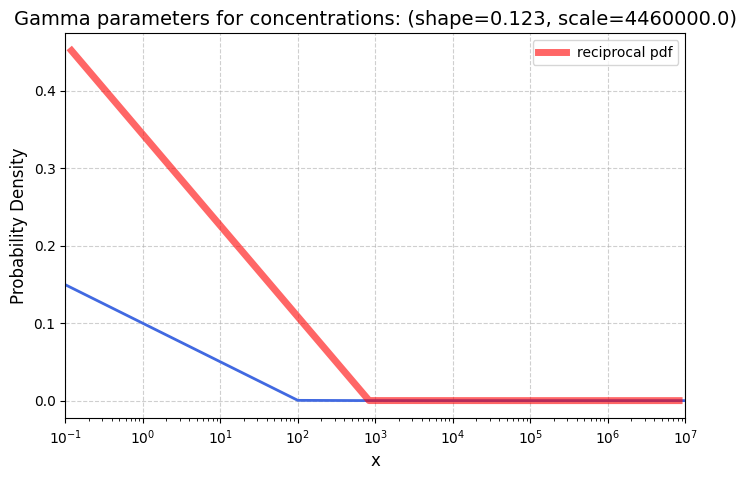

In [662]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, reciprocal

# recipriocal distribution
a, b = 1e-1, 1e7
random_numbers = reciprocal.rvs(a, b, size=10000)
mean, var, skew, kurt = reciprocal.stats(a, b, moments='mvsk')
x_rec = np.linspace(reciprocal.ppf(0.01, a, b),
                reciprocal.ppf(0.99, a, b), 10000)

print(mean, var)
# Parameters for the Gamma distribution
# shape = 1.25  # shape parameter (k)
# scale = 0.001  # scale parameter (θ)
x = np.linspace(1e-1, 1e7, 100000)  # range of x values
shape = 0.123 # shape parameter (k)
scale = 4.46e6  #
# Compute the PDF
pdf = gamma.pdf(x, a=shape, scale=scale)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, pdf, linewidth=2, color='royalblue')
plt.title(f"Gamma parameters for concentrations: (shape={shape}, scale={scale})", fontsize=14)
plt.plot(x_rec, reciprocal.pdf(x_rec, a, b),
       'r-', lw=5, alpha=0.6, label='reciprocal pdf')
plt.xlabel("x", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(1e-1, 1e7)
plt.xscale('log')
plt.legend()
plt.show()

# Generate 1000 random numbers from the distribution


0.014462006247378293 0.0005146737879820747


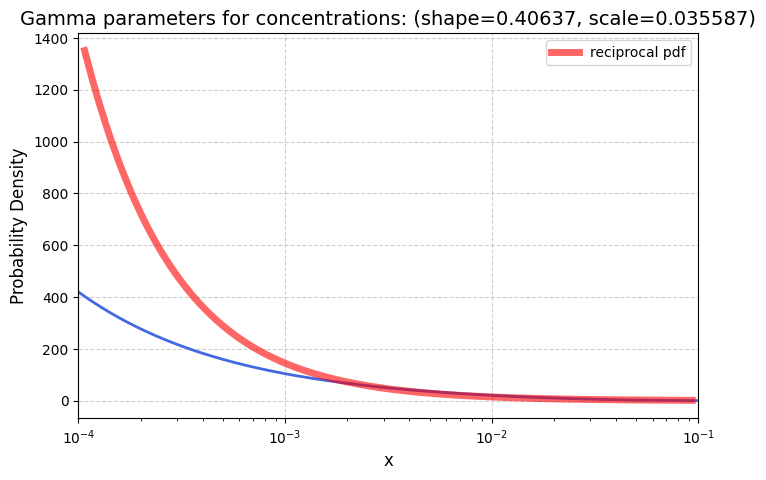

In [666]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, reciprocal

# recipriocal distribution
a, b = 1e-4, 1e-1
random_numbers = reciprocal.rvs(a, b, size=10000)
mean, var, skew, kurt = reciprocal.stats(a, b, moments='mvsk')
x_rec = np.linspace(reciprocal.ppf(0.01, a, b),
                reciprocal.ppf(0.99, a, b), 10000)

print(mean, var)
#Parameters for the Gamma distribution
shape = 1.25  # shape parameter (k)
scale = 0.001  # scale parameter (θ)
x = np.linspace(1e-4, 1e-1, 100000)  # range of x values
shape = 0.40637 # shape parameter (k)
scale = 0.035587 #
# Compute the PDF
pdf = gamma.pdf(x, a=shape, scale=scale)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, pdf, linewidth=2, color='royalblue')
plt.title(f"Gamma parameters for concentrations: (shape={shape}, scale={scale})", fontsize=14)
plt.plot(x_rec, reciprocal.pdf(x_rec, a, b),
       'r-', lw=5, alpha=0.6, label='reciprocal pdf')
plt.xlabel("x", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(1e-4, 1e-1)
plt.xscale('log')
plt.legend()
plt.show()


In [691]:
gen_rates = all_parameter_generation(3, "distributive", "gamma", (0.5, 1000), verbose = False)
alpha_matrix = gen_rates.alpha_parameter_generation()
beta_matrix = gen_rates.beta_parameter_generation()
print(alpha_matrix)
print(np.ravel(alpha_matrix[alpha_matrix != 0]))
# k_positive_rates, k_negative_rates = gen_rates.k_parameter_generation()
# p_positive_rates, p_negative_rates = gen_rates.p_parameter_generation()

[[0.00000000e+00 8.25458015e+02 5.30943628e-02 0.00000000e+00
  6.82634769e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.34269468e+02
  0.00000000e+00 5.92254992e+02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.69487361e+01
  0.00000000e+00 0.00000000e+00 4.27842032e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.75922275e+02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.06691261e+02 3.67925694e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 7.44962254e+02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 9.02254564e+02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]

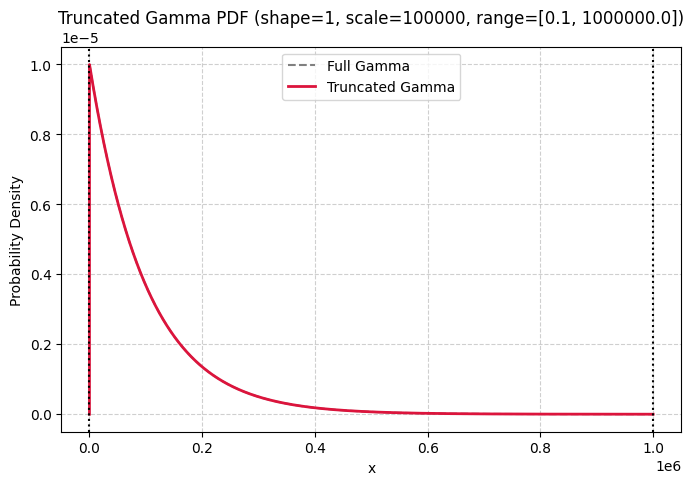

In [217]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

def truncated_gamma_pdf(x, shape, scale=1.0, x_min=0.0, x_max=np.inf):
    """
    Compute the PDF of a Gamma distribution truncated to [x_min, x_max].
    """
    # Standard gamma pdf and cdf
    pdf = gamma.pdf(x, a=shape, scale=scale)
    cdf_min = gamma.cdf(x_min, a=shape, scale=scale)
    cdf_max = gamma.cdf(x_max, a=shape, scale=scale)

    # Renormalize
    norm = cdf_max - cdf_min
    pdf_trunc = np.where((x >= x_min) & (x <= x_max), pdf / norm, 0.0)
    return pdf_trunc

# Example parameters
shape, scale = 1, 100000
x_min, x_max = 0.1, 1e6
x = np.linspace(0, x_max, 10000)

# Compute PDFs
pdf_full = gamma.pdf(x, a=shape, scale=scale)
pdf_trunc = truncated_gamma_pdf(x, shape, scale, x_min, x_max)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, pdf_full, label='Full Gamma', color='gray', linestyle='--')
plt.plot(x, pdf_trunc, label='Truncated Gamma', color='crimson', linewidth=2)
plt.axvline(x_min, color='black', linestyle=':')
plt.axvline(x_max, color='black', linestyle=':')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title(f'Truncated Gamma PDF (shape={shape}, scale={scale}, range=[{x_min}, {x_max}])')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [640]:
gen_rates = all_parameter_generation(20, "distributive", "gamma", (0.5, 1000), verbose = False)
# alpha_matrix = gen_rates.alpha_parameter_generation()
# beta_matrix = gen_rates.beta_parameter_generation()
k_positive_rates, k_negative_rates = gen_rates.k_parameter_generation()
print(np.mean(k_positive_rates))
print(0.5*1000)

500.54439798971555
500.0
